# Imports and config

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
DATA_FOLDER = "data"
FOLDERS = ["folder_1", "folder_2"]
SEL_FOLDER = FOLDERS[0]

# Data import

In [4]:
files = [f.split(".")[0] for f in os.listdir(f"{DATA_FOLDER}/{SEL_FOLDER}")]
files

['1_1', '1_2', '2_1', '2_2', '3_1', '3_2', '3_3', 'labels']

In [5]:
LABEL_FILENAME = "labels"
labels = pd.read_csv(f"{DATA_FOLDER}/{SEL_FOLDER}/{LABEL_FILENAME}.csv", index_col=0)
train_files = [f for f in files if f != LABEL_FILENAME]

In [32]:
refs = {}
anos = {}

for file in train_files:
    train_file = pd.read_csv(f"{DATA_FOLDER}/{SEL_FOLDER}/{file}.csv", index_col=0)
    train_file["original_file"] = file
    train_file["timestamp"] = train_file.index
    label_file = labels.loc[labels["trace_id"]==file, :]
    for i in label_file.index:
        ano_id =  label_file.loc[i, "ano_id"]
        selection_ref = train_file.loc[(train_file["timestamp"] >= label_file["ref_start"][i]) & (train_file["timestamp"] < label_file["ref_end"][i]), :].copy()
        selection_ref["ano_id"] = ano_id
        selection_ref["type_data"] = 0
        selection_ano = train_file.loc[(train_file["timestamp"] >= label_file["ano_start"][i]) & (train_file["timestamp"] <= label_file["ano_end"][i]), :].copy()
        selection_ano["ano_id"] = ano_id
        selection_ano["type_data"] = 1
        refs[f"{file}_{i}"] = selection_ref
        anos[f"{file}_{i}"] = selection_ano

assert refs.keys() == anos.keys()
refs = pd.concat(refs).droplevel(1)
anos = pd.concat(anos).droplevel(1)
refs.shape, anos.shape

# Single reward function

## Useful functions

In [8]:
def class_entropy(ts_a:list, ts_r:list) -> float:
    """Calculate the class entropy of a feature, which is the information
    needed to describe the class distributions between two time serie.

    Parameters
    ----------
    tsa : list
        A time series belonging to the abnormal class.
    tsr : list
        A time series belong to the reference class.

    Returns
    -------
    float
        The class entropy.
    """
    nb_ts_a = len(ts_a)
    nb_ts_r = len(ts_r)
    if nb_ts_a == 0 or nb_ts_r == 0:
        raise ValueError(f"One of the time series is empty. Len of TSA is {nb_ts_a} and len of TSR is {nb_ts_r}.")
    p_a = nb_ts_a / (nb_ts_a + nb_ts_r)
    p_r = nb_ts_r / (nb_ts_a + nb_ts_r)
    h_class = p_a * np.log2(p_a) + p_r * np.log2(p_r)
    return h_class

In [199]:
def shuffle_observations_if_duplicates(sorted_values:pd.DataFrame, feature)-> pd.DataFrame:
    """Shuffle the observations if there are duplicates in the sorted values.

    Parameters
    ----------
    sorted_values : pd.DataFrame
        The sorted values.

    Returns
    -------
    pd.DataFrame
        The sorted values with shuffled values for duplicates.
    """

    # On récupère le nombre de références et d'anomalies pour chaque modalité
    value_type_to_count = sorted_values.groupby(feature).value_counts().to_dict()

    # On récupère le nombre de valeurs distinctes pour chaque modalité (soit 1 lorsque pas de doublons, soit 2, lorsqu'il y a des doublons)
    value_to_count_distinct = sorted_values.drop_duplicates().groupby(feature).count().to_dict()['type_data']

    # On récupère les modalités distinctes (les différentes valeurs prises par la feature)
    modalities = set(sorted_values[feature].tolist())
    # En fait, ce qui est un peu bizarre c'est qu'on a des valeurs continues, mais là on va les traiter comme des valeurs discrètes :
    # Par exemple si on considère une colonne qui prend les valeurs 501.03, 501.03, 502.4, 502.4, 505.0, on itère sur 501.03, 502.4, 505.0
    
    # On parcourt chaque modalité
    for modality in modalities:
        # On récupère le premier type de données observé (ano ou ref, donc 1 ou 0) (ça nous sera utile plus tard)
        last_type_data = sorted_values.loc[sorted_values[feature]==modality, "type_data"].tolist()[0]

        # Cas où il n'y a pas de doublons
        if value_to_count_distinct[modality] == 1:
            # On ne fait rien
            continue
        
        # Cas où il y a des doublons
        else:            
            # On va shuffle dans le pire ordre possible

            # D'abord on instancie les variables nécessaires
            list_values = []
            nb_refs = value_type_to_count[(modality, 0)]
            nb_anos = value_type_to_count[(modality, 1)]
            nb_total = nb_refs + nb_anos
            # Hop maintenant c'est parti pour le shuffle

            # Cas où il n'y a pas le même nombre de références et d'anomalies (cas le plus chiant)
            if nb_refs != nb_anos:
                # On instancie de nouveau des variables nécessaires
                biggest = int(nb_refs < nb_anos) # 1 si on a plus d'anomalies que de références, 0 sinon
                smallest = int(nb_refs > nb_anos) # 1 si on a plus de références que d'anomalies, 0 sinon
                nb_smallest = min(nb_refs, nb_anos) # Nombre de fois où on va mettre la valeur la moins représentée

                # On commence par mettre la valeur la plus représentée partout
                list_values = [biggest] * nb_total

                # Puis on cherche si le dernier type de donnée observé est le plus représenté ou le moins représenté pour savoir où commencer
                start_smallest = 0 if smallest != last_type_data else 1

                # On parcourt la liste 2 par 2 pour mettre la valeur la moins représentée
                for i in range(start_smallest, nb_smallest*2, 2):
                    list_values[i] = smallest

            # Cas où il y a le même nombre de références et d'anomalies (cas le plus simple)
            else:
                # On parcourt le nombre total d'observations
                for i in range(nb_total):
                    # On alterne entre 0 et 1 en commençant par la valeur opposée à la dernière valeur observée
                    list_values.append(abs(last_type_data-i%2-1))

            # On récupère le dernier type de donnée observé (toujours 1 ou 0)   
            last_type_data = sorted_values.loc[sorted_values[feature]==modality, "type_data"].tolist()[-1]

        # On vérifie que la longueur de la liste est bien égale au nombre d'observations pour la modalité   
        assert len(list_values) == sorted_values[sorted_values[feature]==modality].shape[0], f"Len of list_values {len(list_values)} is not equal to the number of observations for the modality {sorted_values[sorted_values[feature]==modality].shape[0]}."
        # On met à jour le type de donnée pour la modalité
        sorted_values.loc[sorted_values[feature]==modality, "type_data"] = list_values
        
    return sorted_values

In [200]:
def segmentation_entropy(shuffled_values: pd.DataFrame) -> float:
    """
    Calculate the segmentation entropy of a feature.

    Parameters:
    shuffled_values (pd.DataFrame): A DataFrame containing the shuffled values.

    Returns:
    float: The segmentation entropy of the feature.
    """
    # On récupère la time serie
    ts = shuffled_values["type_data"].tolist() 

    # Stocke la première valeur de la liste
    past_value = ts[0] 

    # Liste pour stocker les valeurs à l'intérieur d'un segment 
    values_inside_segment = [] 

    # Variable pour stocker la segmentation entropy
    segmentation_ent = 0.0  

    # Parcourt chaque valeur dans la time serie
    for value in ts:  
        # Si la valeur est différente de la valeur précédente
        if value != past_value: 
            # On a un nouveau segment, il faut calculer l'entropie de segmentation partielle du précédent segment
            pi = len(values_inside_segment) / shuffled_values.shape[0]  
            segmentation_ent += pi * np.log(1 / pi)

            # On réinitialise la liste des valeurs à l'intérieur du segment avec la nouvelle valeur
            values_inside_segment = [value]  
        else:
            # On stocke les valeurs à l'intérieur du segment tant qu'un nouveau segment n'est pas créé
            values_inside_segment.append(value)  
        
        # On met à jour la valeur précédente avec la valeur actuelle
        past_value = value  

    return segmentation_ent 
    


## Calculate single reward function for each column

In [201]:
distances = {}
for feature in refs.columns[:-4]:
    class_ent = class_entropy(refs.loc[:,feature], anos.loc[:,feature])
    all_values = pd.concat([refs[[feature, "type_data"]], anos[[feature, "type_data"]]])
    sorted_values = all_values.sort_values(by=[feature, "type_data"])
    shuffled_values = shuffle_observations_if_duplicates(sorted_values, feature)
    segmentation_ent = segmentation_entropy(shuffled_values)
    distance = class_ent / segmentation_ent
    distances[feature] = distance

## Verifications (not needed inside reel code)

In [204]:
refs.columns

Index(['driver_StreamingMetrics_streaming_lastCompletedBatch_processingDelay_value',
       'driver_StreamingMetrics_streaming_lastCompletedBatch_schedulingDelay_value',
       'driver_StreamingMetrics_streaming_lastReceivedBatch_records_value',
       'driver_BlockManager_memory_memUsed_MB_value',
       'driver_jvm_heap_used_value',
       'driver_StreamingMetrics_streaming_totalCompletedBatches_value_1_diff',
       'avg_jvm_heap_used_value',
       'avg_executor_filesystem_hdfs_write_ops_value_1_diff',
       'avg_executor_cpuTime_count_1_diff',
       'avg_executor_runTime_count_1_diff',
       'avg_executor_shuffleRecordsRead_count_1_diff',
       'avg_executor_shuffleRecordsWritten_count_1_diff', 'original_file',
       'timestamp', 'ano_id', 'type_data'],
      dtype='object')

In [205]:
biggest_entropy = sorted(distances.items(), key=lambda x: x[1], reverse=True)[0][0]
smallest_entropy = sorted(distances.items(), key=lambda x: x[1], reverse=False)[0][0]

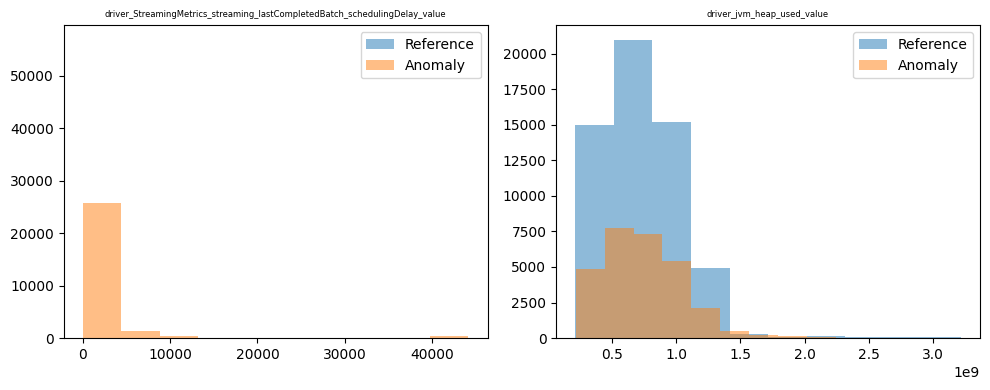

In [213]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs = axs.flatten()
for i, col in enumerate([smallest_entropy, biggest_entropy]):
    axs[i].hist(refs[col].astype(float).tolist(), label="Reference", alpha=0.5)
    axs[i].hist(anos[col].astype(float).tolist(), label="Anomaly", alpha=0.5)

    axs[i].set_title(col, fontsize=6)
    axs[i].legend()

plt.tight_layout()
plt.show()

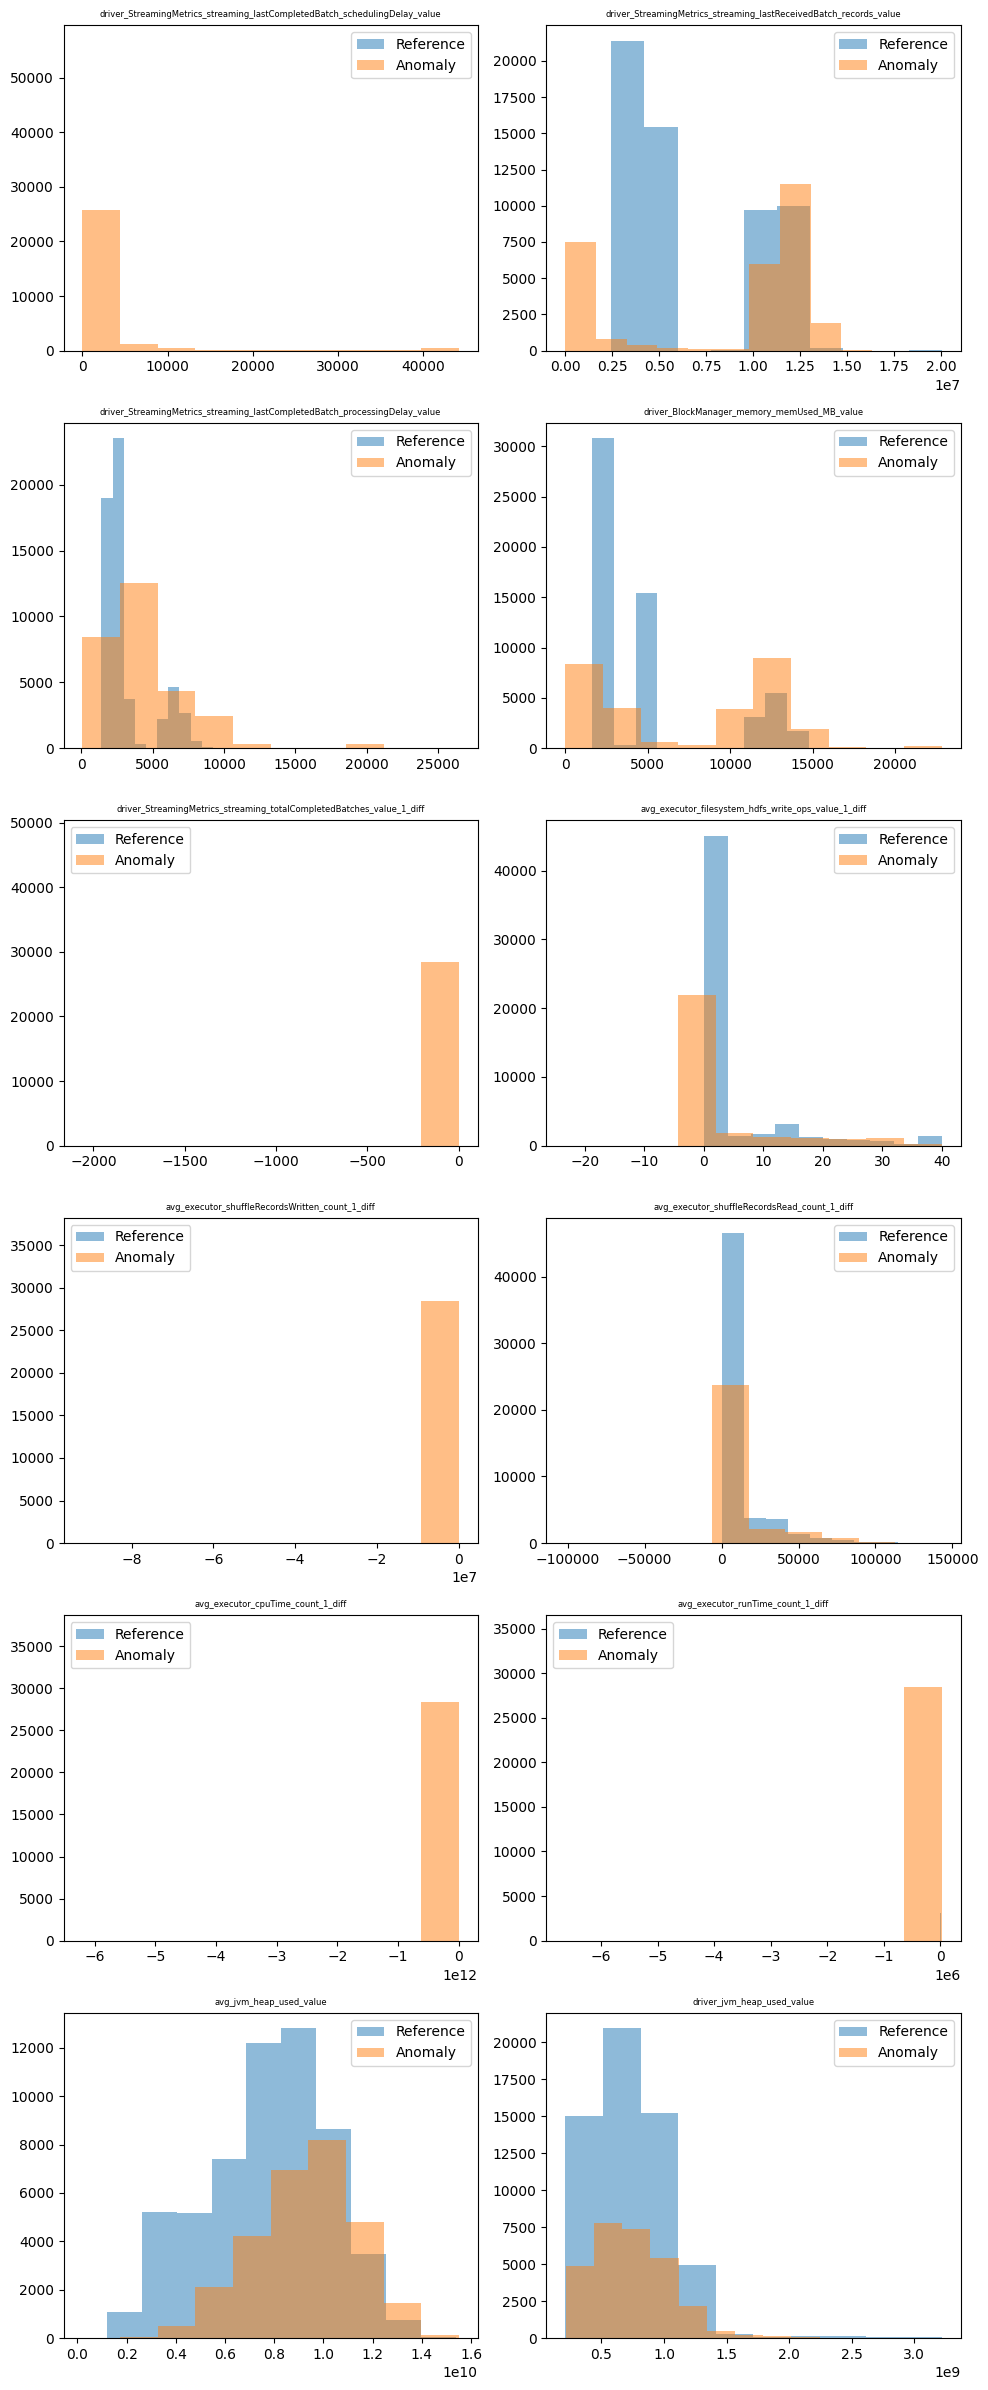

In [212]:
fig, axs = plt.subplots(int(len(refs.columns[:-4])/2), 2, figsize=(10, 2*len(refs.columns[:-4])))

axs = axs.flatten()
for i, item in enumerate(sorted(distances.items(), key=lambda x: x[1])):
    col = item[0]
    axs[i].hist(refs[col].astype(float).tolist(), label="Reference", alpha=0.5)
    axs[i].hist(anos[col].astype(float).tolist(), label="Anomaly", alpha=0.5)

    axs[i].set_title(col, fontsize=6)
    axs[i].legend()

plt.tight_layout()
plt.show()


# Constructing explanation

In [149]:
distances = {}
for file in train_files:
    ano_ids = list(labels.loc[labels["trace_id"]==file, "ano_id"])
    for ano_id in ano_ids:
        selected_ref = refs.loc[(refs["ano_id"]==ano_id) & (refs["original_file"]==file), :]
        selected_ano = anos.loc[(anos["ano_id"]==ano_id) & (anos["original_file"]==file), :]
        
        break
        

In [147]:
shuffled_values

,driver_StreamingMetrics_streaming_lastCompletedBatch_processingDelay_value,type_data
3_2_28,5352.0,0
3_2_28,5352.0,0
3_2_28,5352.0,0
3_2_28,5352.0,0
3_2_28,5352.0,0
...,...,...
3_2_28,10050.0,1
3_2_28,10050.0,1
3_2_28,10050.0,1
3_2_28,10050.0,1
